<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/GMAN_net/gman_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing and loading of data

In [3]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [4]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [5]:
# function to get the path of individual image.
'''
def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img
    '''

"\ndef data_path(orig_img_path, hazy_img_path):\n    \n    train_img = []\n    val_img = []\n    \n    orig_img = glob.glob(orig_img_path + '/*.jpg')\n    n = len(orig_img)\n    random.shuffle(orig_img)\n    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test\n    val_keys = orig_img[int(0.9*n):]\n    \n    split_dict = {}\n    for key in train_keys:\n        split_dict[key] = 'train'\n    for key in val_keys:\n        split_dict[key] = 'val'\n        \n    hazy_img = glob.glob(hazy_img_path + '/*.jpg')\n    for img in hazy_img:\n        img_name = img.split('/')[-1]\n        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'\n        if (split_dict[orig_path] == 'train'):\n            train_img.append([img, orig_path])\n        else:\n            val_img.append([img, orig_path])\n            \n    return train_img, val_img\n    "

In [14]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.05,validation_size=64,test_size=64,seed_val=101):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [7]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [8]:
# function to display output.

def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

# Network Function

In [4]:
class gman_net():

In [5]:
model=gman_net()
model.build([413,550,3])
model.summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

TypeError: ignored

In [26]:
# Hyperparameters
epochs =1
batch_size = 8
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = '/content/drive/MyDrive/dataset/clear_images', hazy_img_path = '/content/drive/MyDrive/dataset/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = gman_net()
#net= tf.keras.models.load_model('/content/drive/MyDrive/demo/gman/saved_model',compile=False)
net= net.load_weights('/content/drive/MyDrive/nets/gman/weights')
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09a2170450> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a24e2a10>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09a2170450> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a24e2a10>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09a249b850> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a20a5210>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09a249b850> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a20a5210>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09a21c4790> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09958ae510>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09a21c4790> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09958ae510>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0994c5ce50> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a20470d0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0994c5ce50> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a20470d0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0995100a10> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a2047cd0>).



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0995100a10> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x7f09a2047cd0>).


ValueError: ignored

In [20]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 WARNING:tensorflow:5 out of the last 1032 calls to <function TensorFlowOpLayer._defun_call at 0x7f09a2dee9e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


[=WARNING:tensorflow:5 out of the last 590 calls to <function TensorFlowOpLayer._defun_call at 0x7f09a2dee9e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


]  -  Training Loss: 0.0054

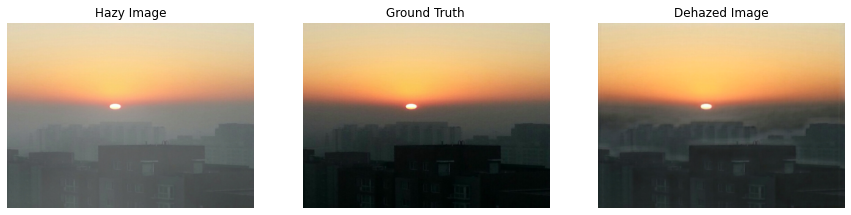

  -  Validation Loss: 0.0045  -   Time taken: 307.18s
INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets


CPU times: user 45.1 s, sys: 22.9 s, total: 1min 7s
Wall time: 5min 12s


In [17]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [18]:
net.save('./drive/MyDrive/nets/gman')
model=net
net.save_weights('/content/drive/MyDrive/nets/gman/weights')
#model.build([412,548,3])
#model.summary()

INFO:tensorflow:Assets written to: ./drive/MyDrive/nets/gman/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/nets/gman/assets


In [21]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #test_img=glob.glob('/content/drive/MyDrive/Final_compare/gman/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (412,548), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        dehaze=tf.image.resize(dehaze, size = (413,550), antialias = True)
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/gman/trans'
        #directory = '/content/drive/MyDrive/Final_compare/LoopCompare'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, 

im)

        os.chdir('/content')
        i+=1;



In [22]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gman',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gman/trained_model',compile=False)

evaluate_gen(net)


0 WARNING:tensorflow:5 out of the last 122 calls to <function TensorFlowOpLayer._defun_call at 0x7f09a2dee9e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 

In [ ]:


cp -r trained_model/ /content/drive/MyDrive/nets/dehazenet/trained_model



In [27]:
net1= tf.keras.models.load_model('/content/drive/MyDrive/demo/gman/saved_model',compile=False)

In [28]:
net1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 412, 548, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 412, 548, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 206, 274, 128 73856       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [32]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 412, 548, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 412, 548, 64) 36928       conv2d_120[0][0]                 
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 206, 274, 128 73856       conv2d_121[0][0]                 
____________________________________________________________________________________________

In [16]:
from tensorflow.python.training import py_checkpoint_reader
def print_tensors_in_checkpoint_file(file_name, tensor_name, all_tensors,
                                     all_tensor_names=False,
                                     count_exclude_pattern=""):
  """Prints tensors in a checkpoint file.
  If no `tensor_name` is provided, prints the tensor names and shapes
  in the checkpoint file.
  If `tensor_name` is provided, prints the content of the tensor.
  Args:
    file_name: Name of the checkpoint file.
    tensor_name: Name of the tensor in the checkpoint file to print.
    all_tensors: Boolean indicating whether to print all tensors.
    all_tensor_names: Boolean indicating whether to print all tensor names.
    count_exclude_pattern: Regex string, pattern to exclude tensors when count.
  """
  try:
    reader = py_checkpoint_reader.NewCheckpointReader(file_name)
    if all_tensors or all_tensor_names:
      var_to_shape_map = reader.get_variable_to_shape_map()
      var_to_dtype_map = reader.get_variable_to_dtype_map()
      for key, value in sorted(var_to_shape_map.items()):
        print("tensor: %s (%s) %s" % (key, var_to_dtype_map[key].name, value))
        if all_tensors:
          print(reader.get_tensor(key))
    elif not tensor_name:
      print(reader.debug_string().decode("utf-8", errors="ignore"))
    else:
      if not reader.has_tensor(tensor_name):
        print("Tensor %s not found in checkpoint" % tensor_name)
        return

      var_to_shape_map = reader.get_variable_to_shape_map()
      var_to_dtype_map = reader.get_variable_to_dtype_map()
      print("tensor: %s (%s) %s" %
            (tensor_name, var_to_dtype_map[tensor_name].name,
             var_to_shape_map[tensor_name]))
      print(reader.get_tensor(tensor_name))

    # Count total number of parameters
    print("# Total number of params: %d" % _count_total_params(
        reader, count_exclude_pattern=count_exclude_pattern))
  except Exception as e:  # pylint: disable=broad-except
    print(str(e))
    if "corrupted compressed block contents" in str(e):
      print("It's likely that your checkpoint file has been compressed "
            "with SNAPPY.")
    if ("Data loss" in str(e) and
        any(e in file_name for e in [".index", ".meta", ".data"])):
      proposed_file = ".".join(file_name.split(".")[0:-1])
      v2_file_error_template = """
It's likely that this is a V2 checkpoint and you need to provide the filename
*prefix*.  Try removing the '.' and extension.  Try:
inspect checkpoint --file_name = {}"""
      print(v2_file_error_template.format(proposed_file))
#print_tensors_in_checkpoint_file(file_name='/content/drive/MyDrive/demo/gman/checkpoints/model.ckpt-5000', tensor_name='', all_tensors=True).shape

In [17]:
ckpt_reader = tf.train.load_checkpoint('/content/drive/MyDrive/demo/gman/checkpoints/model.ckpt-5000')
value = ckpt_reader.get_tensor(name_of_the_tensor)

NameError: ignored

In [21]:
tf.train.list_variables('/content/drive/MyDrive/demo/gman/checkpoints/model.ckpt-5000'   
)

[('DehazeNet/DN_conv1_1/biases', [64]),
 ('DehazeNet/DN_conv1_1/biases/Adam', [64]),
 ('DehazeNet/DN_conv1_1/biases/Adam_1', [64]),
 ('DehazeNet/DN_conv1_1/biases/ExponentialMovingAverage', [64]),
 ('DehazeNet/DN_conv1_1/weights', [3, 3, 3, 64]),
 ('DehazeNet/DN_conv1_1/weights/Adam', [3, 3, 3, 64]),
 ('DehazeNet/DN_conv1_1/weights/Adam_1', [3, 3, 3, 64]),
 ('DehazeNet/DN_conv1_1/weights/ExponentialMovingAverage', [3, 3, 3, 64]),
 ('DehazeNet/DN_conv1_2/biases', [64]),
 ('DehazeNet/DN_conv1_2/biases/Adam', [64]),
 ('DehazeNet/DN_conv1_2/biases/Adam_1', [64]),
 ('DehazeNet/DN_conv1_2/biases/ExponentialMovingAverage', [64]),
 ('DehazeNet/DN_conv1_2/weights', [3, 3, 64, 64]),
 ('DehazeNet/DN_conv1_2/weights/Adam', [3, 3, 64, 64]),
 ('DehazeNet/DN_conv1_2/weights/Adam_1', [3, 3, 64, 64]),
 ('DehazeNet/DN_conv1_2/weights/ExponentialMovingAverage', [3, 3, 64, 64]),
 ('DehazeNet/DN_conv2_1/biases', [64]),
 ('DehazeNet/DN_conv2_1/biases/Adam', [64]),
 ('DehazeNet/DN_conv2_1/biases/Adam_1', [64

In [22]:
tf.train.load_variable('/content/drive/MyDrive/demo/gman/checkpoints/model.ckpt-5000','DehazeNet/DN_deconv1/weights')

array([[[[ 6.83947504e-02, -1.63467098e-02,  2.43677036e-03, ...,
           1.88263450e-02,  5.83241088e-03,  1.57084279e-02],
         [ 5.05831465e-02, -2.15049591e-02, -3.75104435e-02, ...,
          -3.14503461e-02, -1.88659038e-02,  1.42134530e-02],
         [-5.25020547e-02, -1.82811711e-02, -9.84280482e-02, ...,
           1.55164208e-02, -1.11791519e-02,  9.48212296e-02],
         ...,
         [-5.12261689e-02, -2.16365345e-02, -5.01585118e-02, ...,
           1.37534877e-02,  6.13709167e-02,  7.04122009e-04],
         [-1.10713951e-02, -2.79031992e-02,  5.75980656e-02, ...,
          -2.88726762e-02, -2.72772741e-02,  1.51389223e-02],
         [ 2.27272287e-02,  3.74514237e-02,  5.29065095e-02, ...,
           4.58294377e-02, -5.06733693e-02, -2.71945558e-02]],

        [[ 7.48729110e-02, -1.00296149e-02,  3.58599201e-02, ...,
           3.27461921e-02, -3.58607322e-02, -5.65902032e-02],
         [-1.68570541e-02,  3.09290458e-03, -3.78771871e-02, ...,
           5.19243143e